Import library

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

**Load Data Set**

In [2]:
(train_images, _), (_, _) = fashion_mnist.load_data()
train_images = train_images[:10000]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
#### Preproceese image
train_images = (train_images.astype('float32') - 127.5) / 127.5
train_images = np.expand_dims(train_images, axis=-1)  # Add channel dimension

####
BUFFER_SIZE = 60000
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


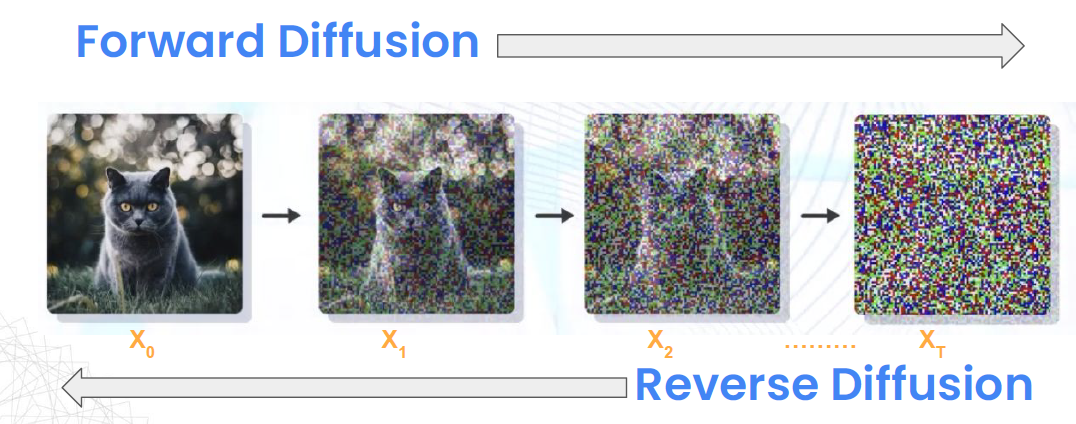

# **Diffusion proccese**

## Forward Diffusion Function

The **forward diffusion** function gradually adds Gaussian noise to an image over time. It is essential for:

- Training the model to **denoise** at each step.
- Smoothly transitioning images to **random noise**.
- Breaking down the generation task into **manageable steps**.
- **Stabilizing training** by controlling noise addition.

### Equation:

$$
\tilde{x}_t = \sqrt{\alpha_t} \cdot x + \sqrt{1 - \alpha_t} \cdot \epsilon
$$

Where:
- $\tilde{x}_t \$ is the noisy image at timestep \( t \).

- $\alpha_t \$ is a noise schedule parameter.

- $\epsilon \$ is Gaussian noise.


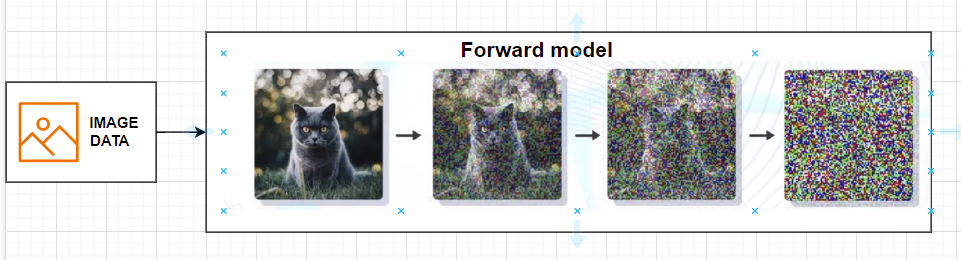

In [4]:
## Aim is to add Gaussian noise to image
def forward_diffusion(x, t, noise_schedule):
    """Adds Gaussian noise to an image `x` at a time step `t`."""
    noise = tf.random.normal(shape=x.shape, dtype=tf.float32)  # Ensure noise is float32
    alpha_t = tf.cast(noise_schedule[t], tf.float32)  # Cast alpha_t to float32
    return tf.sqrt(alpha_t) * x + tf.sqrt(1 - alpha_t) * noise

Noise schedule : This will add Noise in each time step

In [5]:
# Cosine noise schedule function for better stability
def cosine_noise_schedule(timesteps, s=0.008):
    """Creates a cosine noise schedule to stabilize the diffusion process."""
    steps = np.linspace(0, timesteps, timesteps)
    return np.cos((steps / timesteps + s) / (1 + s) * np.pi / 2) ** 2

In [6]:
# Parameters
T = 100        # Number of timesteps in the diffusion process
epsilon = 1e-5

# Create a cosine noise schedule and convert to TensorFlow tensor
noise_schedule = cosine_noise_schedule(T)
noise_schedule = tf.convert_to_tensor(noise_schedule, dtype=tf.float32)

In [7]:
noise_schedule

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([9.99844611e-01, 9.99204576e-01, 9.98069823e-01, 9.96441483e-01,
       9.94321167e-01, 9.91711020e-01, 9.88613546e-01, 9.85031903e-01,
       9.80969548e-01, 9.76430535e-01, 9.71419454e-01, 9.65941131e-01,
       9.60001111e-01, 9.53605235e-01, 9.46759820e-01, 9.39471602e-01,
       9.31747973e-01, 9.23596442e-01, 9.15025115e-01, 9.06042516e-01,
       8.96657526e-01, 8.86879444e-01, 8.76717925e-01, 8.66183162e-01,
       8.55285466e-01, 8.44035685e-01, 8.32444966e-01, 8.20524812e-01,
       8.08286965e-01, 7.95743704e-01, 7.82907248e-01, 7.69790530e-01,
       7.56406426e-01, 7.42768168e-01, 7.28889406e-01, 7.14783728e-01,
       7.00465262e-01, 6.85948133e-01, 6.71246707e-01, 6.56375587e-01,
       6.41349494e-01, 6.26183331e-01, 6.10892117e-01, 5.95491052e-01,
       5.79995275e-01, 5.64420283e-01, 5.48781395e-01, 5.33094227e-01,
       5.17374218e-01, 5.01637042e-01, 4.85898197e-01, 4.70173329e-01,
       4.54478055e-01, 4.3882

# **Reverse Process**



- The **goal of the reverse process** is to remove noise step by step, recovering the original image.
- The **U-Net** acts as the denoising model in this reverse process:
  - At each time step, it takes the **noisy image** as input.
  - It **predicts the amount of noise** added at that step.
  - The predicted noise is **subtracted** from the noisy image to progressively denoise it.
  - This process continues, bringing the image closer to its **original, noise-free state**.




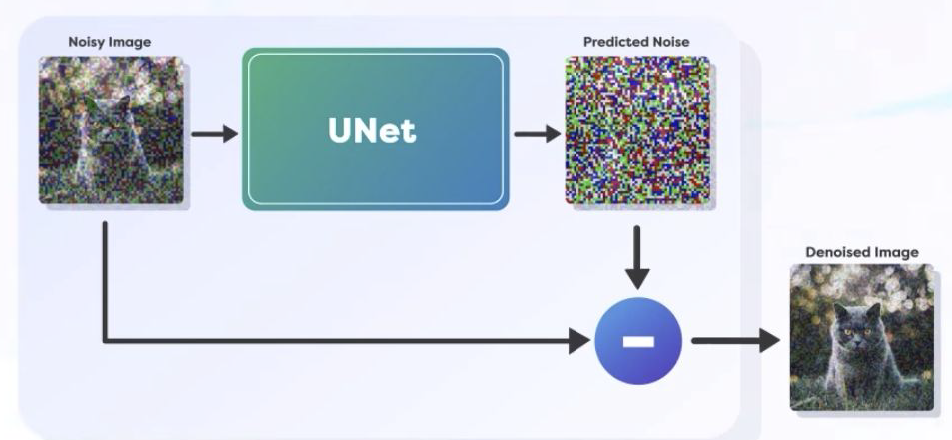

In [12]:
def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    ###### Downsampling
    x = layers.Conv2D(64, 3, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)

    ###### Bottleneck
    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.LeakyReLU()(x)

    ##### Upsampling
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)

    outputs = layers.Conv2D(1, 1, padding='same')(x)

    model = models.Model(inputs, outputs)
    return model

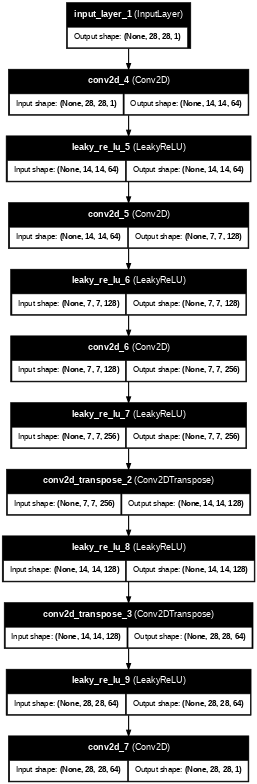

In [11]:
from tensorflow.keras.utils import plot_model
input_shape = (28, 28, 1)
model = unet_model(input_shape)
plot_model(model, to_file='unet_model.png', show_shapes=True, show_layer_names=True,dpi=40)

Loss function

In [14]:
# Loss function: Mean squared error to match the predicted noise to the actual noise
loss_fn = tf.keras.losses.MeanSquaredError()

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

*In diffusion models, at each time step, a certain amount of noise is added to the image. The model is then trained to learn how to reverse this noise (denoise the image). To make the model more robust, we want it to learn how to denoise images with different amounts of noise, which are added at different timesteps.*


*  If you have a batch of images (say 32 images), this function will give you 32 random timesteps, one for each image. Some images might get noise from step 10, some from step 20, and so on.

*   We want the model to learn how to remove noise from images that are at different stages of the diffusion process (different timesteps). This way, the model becomes good at denoising images, whether they are heavily or lightly noised.



In [16]:
def get_random_timestep(batch_size, T):
    return tf.fill([batch_size], tf.random.uniform(shape=[], minval=0, maxval=T, dtype=tf.int32))

# **Train model**

In [18]:
@tf.function
def train_step(images, noise_schedule, t):
    with tf.GradientTape() as tape:
        #### Add noise
        noised_images = forward_diffusion(images, t, noise_schedule)

        #### Predict noise using model (UNET)
        predicted_noise = model(noised_images)

        #### Generate actual noise  ( see formula )
        actual_noise = noised_images - tf.sqrt(tf.cast(noise_schedule[t], tf.float32)) * images

        #### Compute the loss (between predicted noise and actual noise)
        loss = loss_fn(predicted_noise, actual_noise)

    ##### Backpropagate and update model weights
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [20]:
EPOCHS = 2

for epoch in range(EPOCHS):
    for batch, images in enumerate(train_dataset):
        # Randomly sample a timestep t
        t = np.random.randint(0, T)

        # Perform a training step
        loss = train_step(images, noise_schedule, t)

    print(f'Epoch {epoch+1}, Loss: {loss.numpy()}')

Epoch 1, Loss: 0.09939958155155182
Epoch 2, Loss: 0.09238586574792862
